# Pixel clustering notebook

In [2]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
from matplotlib import rc_file_defaults
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import pixel_cluster_utils
from ark.utils import data_utils, example_dataset, io_utils, load_utils, plot_utils
from ark.utils.metacluster_remap_gui import colormap_helper, MetaClusterData, MetaClusterGui, metaclusterdata_from_files

## 0: set file paths and parameters

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from `Segment_Image_Data.ipynb`). This directory will also store all of the directories/files created during pixel clustering.
* `tiff_dir`: the path to the directory containing your imaging data
* `img_sub_folder`: if `tiff_dir` contains an additional subfolder structure, override `None` with the appropriate value
* `segmentation_dir`: the path to the directory containing your segmentations (generated from `Segment_Image_Data.ipynb`). Set this argument to `None` if you do not have segmentation labels or wish to run pixel clustering without them. However, note that you will not be able to run cell clustering as that process is heavily dependent on them.
* `seg_suffix`: the suffix plus the file extension of the segmented images for each FOV. Note that these should be the same for all FOVs and that normally, the value should be `'_whole_cell.tiff'`. This argument will be ignored if `segmentation_dir` is set to `None`

In [ ]:
base_dir = "../data/example_dataset"

In [3]:
tiff_dir = os.path.join(base_dir, "image_data")
img_sub_folder = None
segmentation_dir = "segmentation"
deepcell_output_dir = os.path.join(segmentation_dir, "deepcell_output")
seg_suffix = '_whole_cell.tiff'

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`. 

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

In [ ]:
example_dataset.get_example_dataset(dataset="cluster_pixels", save_dir = base_dir, overwrite_existing = False)

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in `tiff_dir`

In [4]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov14"]

### Define multiprocessing parameters

Turning on multiprocessing provides a speed boost, however it is not always cross-platform compatible. If you receive errors such as hanging cells without progress updates, `ncores` set to `NA`, or `fovStatuses` of length 0, try setting `multiprocess` back to `False`.

In [ ]:
# set to True to turn on multiprocessing
multiprocess = False

# define the number of FOVs to process in parallel, ignored if multiprocessing is set to False
batch_size = 5

## 1: Preprocess

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used.

In [5]:
# explicitly set pixel_cluster_prefix to override datetime default
pixel_cluster_prefix = "example"

if pixel_cluster_prefix is None:
    pixel_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

The following data directories/files will be created for preprocessing with names prefixed by `pixel_cluster_prefix`:

* `pixel_output_dir`: the name of the folder to store the pixel clustering directories/files
* `preprocessed_dir`: the name of the directory to save the preprocessed pixel data
* `subsetted_dir`: the name of the directory to save the subsetted pixel data
* `norm_vals_name`: file name to store the values used to normalize each channel on the full preprocessed dataset when assigning pixel SOM cluster labels.

In [16]:
# define the base output pixel folder using the specified pixel cluster prefix
pixel_output_dir = os.path.join("pixie", "%s_pixel_output_dir" % pixel_cluster_prefix)
if not os.path.exists(os.path.join(base_dir, pixel_output_dir)):
    os.makedirs(os.path.join(base_dir, pixel_output_dir))

# define the preprocessed pixel data folders
pixel_data_dir = os.path.join(pixel_output_dir, 'pixel_mat_data')
pixel_subset_dir = os.path.join(pixel_output_dir, 'pixel_mat_subset')
norm_vals_name = os.path.join(pixel_output_dir, 'post_rowsum_chan_norm.feather')

For certain channels, such as membraneous tumor markers, the subcellular localization of the marker isn't important. Instead, what matters is that cells which are positive for the marker show up as positive. In these cases, we have sometimes found it useful to add additional blurring to these markers before clustering. This ensures that more of the pixels within the cell are positive for the marker, instead of only a few pixels at the border, especially for cells which are under-segmented. However, higher blur levels will also cause more of the pixels in neighboring cells to show up as positive. Therefore, this works best when you have other, robust markers (like CD45) which you can use to determine which cells are false positives for the blurred channel. If you have markers in your panel which fit this description, you can add them in the cell below. Then, when specifying the list of markers to include for clustering, make sure to add `{marker_name}_smoothed`, as that is what the tiff will be called

In [17]:
# set an optional list of markers for additional blurring
blurred_channels = ["ECAD"]
smooth_vals = 6

pixel_cluster_utils.smooth_channels(
    fovs=fovs,
    tiff_dir=tiff_dir,
    img_sub_folder=img_sub_folder,
    channels=blurred_channels,
    smooth_vals=smooth_vals,
)

Sometimes, markers will have background staining that you'll want to filter out for the clustering process. Define the name of the marker you want to filter using `filter_channel`. If the marker is only present in the nucleus, set `exclude = False` to filter it out from the membrane. Conversely, if the marker is only present in the membrane, set `exclude = True` to filter it out from the nucleus.

When specifying the list of markers to include for clustering, make sure to add `{marker_name}_nuc_exclude` or `{marker_name}_nuc_include` depending on what type of signal was filtered out.

Skip this cell if you don't want to run marker filtering.

In [18]:
filter_channel = 'CD163'
nuclear_exclude = True

pixel_cluster_utils.filter_with_nuclear_mask(
    fovs,
    tiff_dir,
    os.path.join(base_dir, deepcell_output_dir),
    filter_channel,
    img_sub_folder,
    nuclear_exclude
)

Set the following arguments

* `channels`: set a subset to run pixel clustering over.
* `blur_factor`: the sigma to use for the Gaussian filter when running the Gaussian blur. Higher values are more aggressive in smoothing signal.
* `subset_proportion`: the fraction of pixels to take from each fov. Sampling is random.

In [19]:
channels = ["CD3", "CD4", "CD8", "CD14", "CD20", "CD31", "CD45", "CD68",
            "CD163_nuc_exclude", "CK17", "Collagen1", "Fibronectin", 
            "ECAD_smoothed", "HLADR", "SMA", "Vim"]
blur_factor = 2
subset_proportion = 0.1

During pixel preprocessing, the following is done for each FOV:

* Gaussian blur each channel separately
* Remove empty pixels
* For the remaining pixels, normalize each channel by the sum of all the channels, this creates the full preprocessed dataset
* Subset a `subset_proportion` fraction of non-empty, normalized pixels, this creates the subsetted dataset

Note: if you get integer overflow errors loading in your data, try changing the `dtype` argument to a larger type.

In [ ]:
# run pixel data preprocessing
pixel_cluster_utils.create_pixel_matrix(
    fovs,
    channels,
    base_dir,
    tiff_dir,
    os.path.join(base_dir, deepcell_output_dir),
    img_sub_folder=img_sub_folder,
    seg_suffix=seg_suffix,
    pixel_cluster_prefix=pixel_cluster_prefix,
    pixel_output_dir=pixel_output_dir,
    data_dir=pixel_data_dir,
    subset_dir=pixel_subset_dir,
    norm_vals_name=norm_vals_name,
    blur_factor=blur_factor,
    subset_proportion=subset_proportion,
    multiprocess=multiprocess,
    batch_size=batch_size
)

## 2: pixel clustering

### 2.1: train pixel SOM

The following data directories/files will be created for pixel clustering:

* `pixel_weights_name`: file name to place the pixel SOM weights
* `pixel_som_to_meta_name`: file name to store the mapping between pixel SOM clusters and pixel meta clusters
* `pc_chan_avg_som_cluster_name`: file name to store the average channel expression across all pixel SOM clusters
* `pc_chan_avg_meta_cluster_name`: same as above except for pixel meta clusters
* `pixel_meta_cluster_remap_name`: for the meta cluster remapping process, the file to store the new SOM to meta mappings

In [22]:
pixel_weights_name = os.path.join(pixel_output_dir, 'pixel_weights.feather')
pixel_som_to_meta_name = os.path.join(pixel_output_dir, 'pixel_som_to_meta.feather')
pc_chan_avg_som_cluster_name = os.path.join(pixel_output_dir, 'pixel_channel_avg_som_cluster.csv')
pc_chan_avg_meta_cluster_name = os.path.join(pixel_output_dir, 'pixel_channel_avg_meta_cluster.csv')
pixel_meta_cluster_remap_name = os.path.join(pixel_output_dir, 'pixel_meta_cluster_mapping.csv')

Train the pixel SOM on the subsetted data. Training is done using the `FlowSOM` algorithm.

Note that each channel is normalized by their 99.9% value across the entire subsetted dataset before training. These values get saved to `norm_vals_name`.

For a full set of parameters you can customize for `train_pixel_som`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.pixel_cluster_utils.train_pixel_som>pixel training docs</a>.

In [ ]:
# create the pixel-level SOM weights
pixel_cluster_utils.train_pixel_som(
    fovs,
    channels,
    base_dir,
    subset_dir=pixel_subset_dir,
    norm_vals_name=norm_vals_name,
    weights_name=pixel_weights_name,
    num_passes=1
)

### 2.2: Assign pixel SOM clusters

Use the SOM weights learned from `train_pixel_som` to assign pixel clusters to the full preprocessed dataset.

Note that each channel is normalized by the respective value stored in `norm_vals_name` (computed in `train_pixel_som`) prior to cluster assignment.

This function also computes the average channel expression across all pixel SOM clusters as well as the number of pixels in each pixel SOM cluster (the data placed in `pc_chan_avg_som_cluster_name`). This is needed for pixel consensus clustering.

In [ ]:
# use pixel SOM weights to assign pixel clusters
pixel_cluster_utils.cluster_pixels(
    fovs,
    channels,
    base_dir,
    data_dir=pixel_data_dir,
    norm_vals_name=norm_vals_name,
    weights_name=pixel_weights_name,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    multiprocess=multiprocess,
    batch_size=batch_size
)

### 2.3: run pixel consensus clustering

With the SOM cluster labels assigned to the full preprocessed pixel data, assign consensus cluster labels. The consensus clusters are trained on the average channel expression across all pixel SOM clusters (the data stored in `pc_chan_avg_som_cluster_name`). These values are z-scored and capped at the value specified in the `cap` argument prior to training: this helps improve the meta clustering process.

After consensus clustering, the following are also computed:

* The average channel expression across all pixel meta clusters, and the number of pixels per meta cluster (the data placed in `pc_chan_avg_meta_cluster_name`)
* The meta cluster mapping for each pixel SOM cluster in `pc_chan_avg_som_cluster_name` (data is resaved, same data except with an associated meta cluster column)

For a full set of parameters you can customize for `pixel_consensus_cluster`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.pixel_cluster_utils.pixel_consensus_cluster>pixel consensus clustering docs</a>

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [ ]:
max_k = 20
cap = 3

# run hierarchical clustering based on pixel SOM cluster assignments
pixel_cluster_utils.pixel_consensus_cluster(
    fovs,
    channels,
    base_dir,
    max_k=max_k,
    cap=cap,
    data_dir=pixel_data_dir,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name=pc_chan_avg_meta_cluster_name,
    clust_to_meta_name=pixel_som_to_meta_name,
    multiprocess=multiprocess,
    batch_size=batch_size
)

## 3: visualize results

### 3.1: use the interactive reclustering results to relabel pixel meta clusters

The visualization shows the z-scored average channel expression per pixel SOM and meta cluster. The heatmaps are faceted by pixel SOM clusters on the left and pixel meta clusters on the right.

## Usage

### Quickstart
- **Select**: Left Click
- **Remap**: **New metacluster** button or Right Click
- **Edit Metacluster Name**: Textbox at bottom right of the heatmaps.

### Selection and Remapping details
- To select a SOM cluster, click on its respective position in the **selected** bar. Click on it again to deselect.
- To select a meta cluster, click on its corresponding color in the **metacluster** bar. Click on it again to deselect.
- To remap the selected clusters, click the **New metacluster** button (alternatively, right click anywhere). Note that remapping an entire metacluster deletes it.
- To clear the selected SOM/meta clusters, use the **Clear Selection** button.
- **After remapping a meta cluster, make sure to deselect the newly created one to prevent unwanted combinations.**

### Other features and notes
- You will likely need to zoom out to see the entire visualization. To toggle Zoom, use Ctrl -/Ctrl + on Windows or ⌘ +/⌘ - on Mac.
- The bars at the top show the number of pixels in each SOM cluster.
- The text box at the bottom right allows you to rename a particular meta cluster. This can be useful as remapping may cause inconsistent numbering.
- Adjust the z-score limit using the slider on the bottom left to adjust your dynamic range.
- When meta clusters are combined or a meta cluster is renamed, the change is immediately saved to `pixel_meta_cluster_remap_name`.
- You won't be able to advance in the notebook until you've clicked `New metacluster` or renamed a meta cluster at least once. If you don't want to make changes, just click `New metacluster` to trigger a save before continuing.

In [ ]:
%matplotlib widget
rc_file_defaults()
plt.ion()

pixel_mcd = metaclusterdata_from_files(
    os.path.join(base_dir, pc_chan_avg_som_cluster_name),
    cluster_type='pixel'
)
pixel_mcd.output_mapping_filename = os.path.join(base_dir, pixel_meta_cluster_remap_name)
pixel_mcg = MetaClusterGui(pixel_mcd, width=17)

Relabel the pixel meta clusters using the mapping.

In [ ]:
pixel_cluster_utils.apply_pixel_meta_cluster_remapping(
    fovs,
    channels,
    base_dir,
    pixel_data_dir,
    pixel_meta_cluster_remap_name,
    pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name,
    multiprocess=multiprocess,
    batch_size=batch_size
)

Generate the color scheme returned by the interactive reclustering process. This will be for visualizing the pixel cluster overlay.

In [32]:
raw_cmap, _ = colormap_helper.generate_meta_cluster_colormap_dict(
    pixel_mcd.output_mapping_filename,
    pixel_mcg.im_cl.cmap
)

### 3.2: pixel cluster overlay (pixel meta clusters only)

Select a small subset of your FOVs to view within this notebook. Or if you wish to generate and save a significant amount of FOVs, the masks will be created and saved in batches.

Files will be written as `{fov_name}_pixel_mask.tiff` in `pixel_output_dir`

In [33]:
# select fovs to display
subset_pixel_fovs = ['fov0', 'fov1']

In [ ]:
# define the path to the channel file
if img_sub_folder is None:
    chan_file = os.path.join(
        io_utils.list_files(os.path.join(tiff_dir, fovs[0]), substrs=['.tiff'])[0]
    )
else:
    chan_file = os.path.join(
        img_sub_folder, io_utils.list_files(os.path.join(tiff_dir, fovs[0], img_sub_folder), substrs=['.tiff'])[0]
    )

# generate and save the pixel cluster masks for each fov in subset_pixel_fovs
data_utils.generate_and_save_pixel_cluster_masks(
    fovs=subset_pixel_fovs,
    base_dir=base_dir,
    save_dir=os.path.join(base_dir, pixel_output_dir),
    tiff_dir=tiff_dir,
    chan_file=chan_file,
    pixel_data_dir=pixel_data_dir,
    pixel_cluster_col='pixel_meta_cluster',
    sub_dir='pixel_masks',
    name_suffix='_pixel_mask',
)

Load a subset of the pixel cluster masks that you would like to preview.

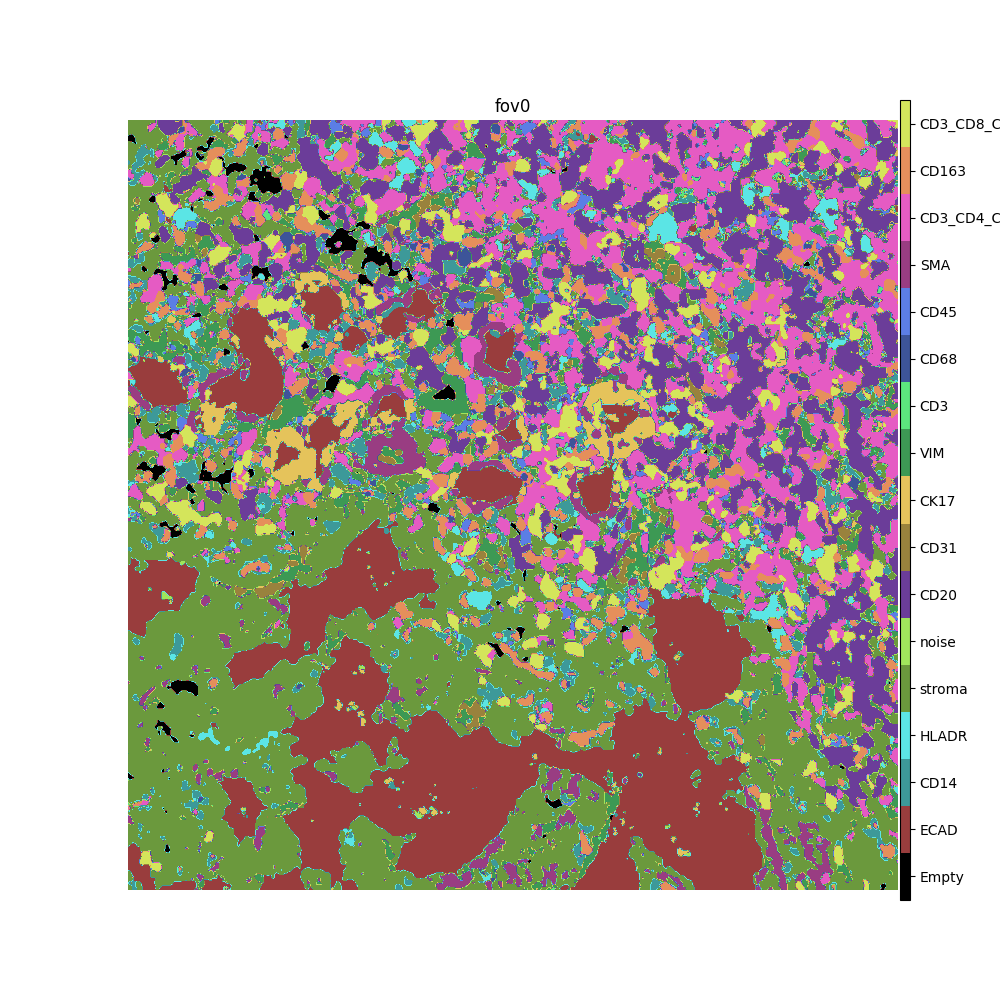

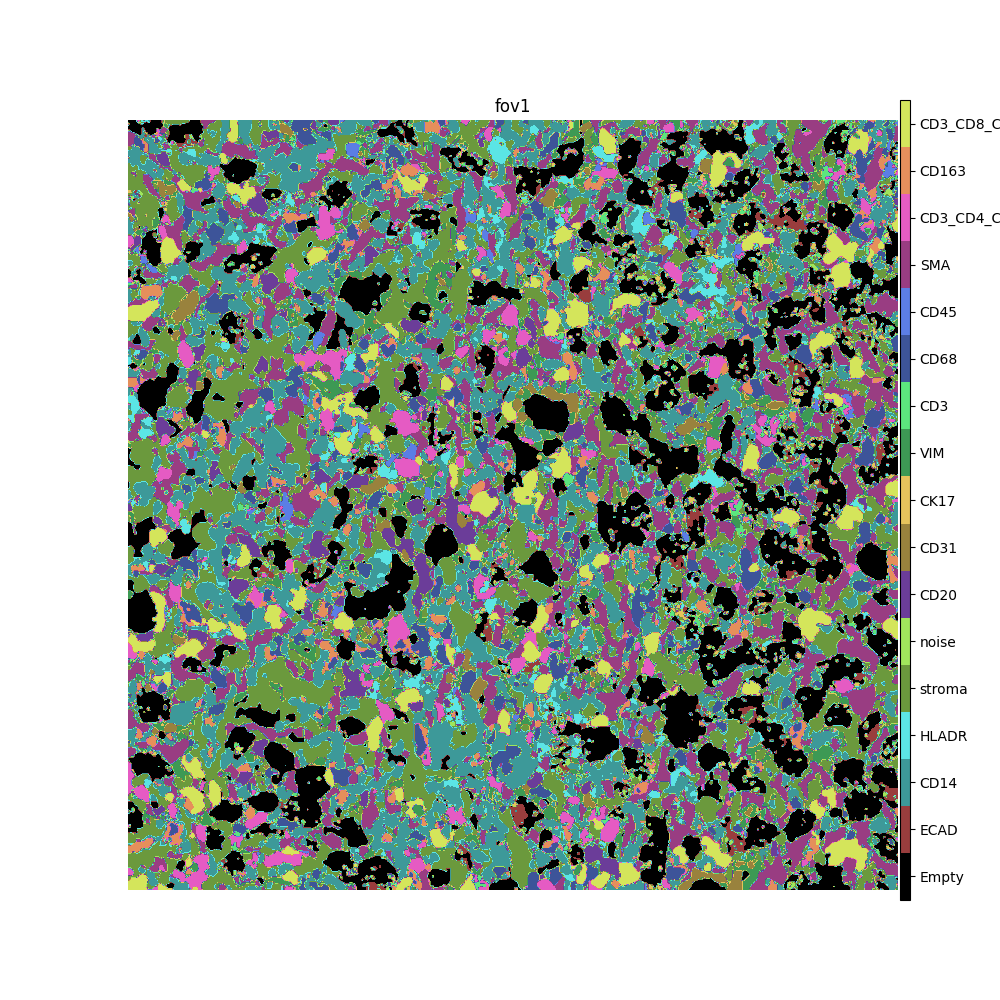

In [37]:
for pixel_fov in subset_pixel_fovs:
    pixel_cluster_mask = load_utils.load_imgs_from_dir(
        data_dir=os.path.join(base_dir, pixel_output_dir, "pixel_masks"),
        files=[pixel_fov + "_pixel_mask.tiff"],
        trim_suffix="_pixel_mask",
        match_substring="_pixel_mask",
        xr_dim_name="pixel_mask",
        xr_channel_names=None,
    )

    plot_utils.plot_pixel_cell_cluster_overlay(
        pixel_cluster_mask,
        [pixel_fov],
        os.path.join(base_dir, pixel_meta_cluster_remap_name),
        metacluster_colors=raw_cmap
    )

### 4: Save parameters for use in cell clustering

The following parameters are saved:

* `fovs`: the subset of fovs in `pixel_data_dir` (may not be the same as the original fov list specified due to potential removal of corrupted fovs)
* `channels`: the subset of channels
* `segmentation_dir`: the path to the directory containing your segmentated images per FOV (generated from `Segment_Image_Data.ipynb`)
* `seg_suffix`: the suffix plus the file extension of the segmented images for each FOV
* `pixel_data_dir`: the name of the directory containing tne full pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_som_cluster_name`: the name of the file containing the average channel expression per pixel SOM cluster
* `pc_chan_avg_meta_cluster_name`: same as above except for pixel meta clusters

The save file will be `{pixel_cluster_prefix}_cell_clustering_params.json` and will be placed in `pixel_output_dir`. Note that the `pixel_output_dir` you use in `example_pixel_clustering.ipynb` should be the same as in `example_cell_clustering.ipynb`.

In [38]:
# define the params dict
cell_clustering_params = {
    'fovs': io_utils.remove_file_extensions(io_utils.list_files(os.path.join(base_dir, pixel_data_dir), substrs='.feather')),
    'channels': channels,
    'segmentation_dir': segmentation_dir,
    'seg_suffix': seg_suffix,
    'pixel_data_dir': pixel_data_dir,
    'pc_chan_avg_som_cluster_name': pc_chan_avg_som_cluster_name,
    'pc_chan_avg_meta_cluster_name': pc_chan_avg_meta_cluster_name
}

# save the params dict
with open(os.path.join(base_dir, pixel_output_dir, 'cell_clustering_params.json'), 'w') as fh:
    json.dump(cell_clustering_params, fh)

#### 4.1 Save Images a Mantis Project

Mantis Viewer is a visualization tool for multi-dimensional imaging in pathology. Learn more about Mantis Viewer in the [README](../README.md#mantis-viewer).

In [40]:
plot_utils.create_mantis_dir(
    fovs=subset_pixel_fovs,
    mantis_project_path=os.path.join(base_dir, pixel_output_dir, "mantis"),
    img_data_path=tiff_dir,
    mask_output_dir=os.path.join(base_dir, pixel_output_dir, "pixel_masks"),
    mapping = os.path.join(base_dir, pixel_meta_cluster_remap_name),
    seg_dir=os.path.join(base_dir, deepcell_output_dir),
    mask_suffix="_pixel_mask")